In [38]:
import pandas as pd
import numpy as np

test = pd.read_csv('/content/final_fewshot_test.csv')
train = pd.read_csv('/content/final_fewshot_train.csv')

In [39]:
train=train[['text','class']]
test=test[['text','class']]

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import tensorflow_hub as hub
import keras
import keras.backend as K
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Bidirectional, LSTM
import pickle    
import os
input_text1 = Input(shape=(512,))
x = Dense(256, activation='relu')(input_text1)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
dense_layer = Dense(128, name='dense_layer')(x)
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

model=Model(inputs=[input_text1], outputs=norm_layer)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_layer (Dense)          (None, 128)              

In [42]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(512,))
in_p = Input(shape=(512,))
in_n = Input(shape=(512,))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = model(in_a)
emb_p = model(in_p)
emb_n = model(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [43]:
nn4_small2_train.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 128)          157120      input_6[0][0]                    
                                                                 input_7[0][0]         

In [44]:
unique_train_label=np.array(train['class'].unique().tolist())
labels_train=np.array(train['class'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

In [45]:
def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l],2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k,train_set,unique_train_label,map_train_label_indices,embed):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a=train_set.iloc[idxs_a].values.tolist()
      b=train_set.iloc[idxs_p].values.tolist()
      c=train_set.iloc[idxs_n].values.tolist()

      a = embed(a)
      p = embed(b)
      n = embed(c)
        # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [a,p,n], []

In [46]:
nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit(get_triplets_batch(128,train['text'],unique_train_label,map_train_label_indices,embed), epochs=100,steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 2s 182ms/step - loss: 45.2491
Epoch 2/100
10/10 [==============================] - 2s 178ms/step - loss: 28.8773
Epoch 3/100
10/10 [==============================] - 2s 181ms/step - loss: 13.7412
Epoch 4/100
10/10 [==============================] - 2s 179ms/step - loss: 7.0871
Epoch 5/100
10/10 [==============================] - 2s 182ms/step - loss: 3.3830
Epoch 6/100
10/10 [==============================] - 2s 182ms/step - loss: 1.9942
Epoch 7/100
10/10 [==============================] - 2s 181ms/step - loss: 0.9001
Epoch 8/100
10/10 [==============================] - 2s 180ms/step - loss: 0.9011
Epoch 9/100
10/10 [==============================] - 2s 179ms/step - loss: 1.1437
Epoch 10/100
10/10 [==============================] - 2s 177ms/step - loss: 0.8510
Epoch 11/100
10/10 [==============================] - 2s 180ms/step - loss: 0.7078
Epoch 12/100
10/10 [==============================] - 2s 179ms/step - loss: 0.4708
Epoch 13/1

In [47]:

X_train = model.predict(embed(np.array(train['text'].values.tolist())))
X_test = model.predict(embed(np.array(test['text'].values.tolist())))

y_train = np.array(train['class'].values.tolist())
y_test = np.array(test['class'].values.tolist())

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8764113518462008, SVM accuracy = 0.8748855660665242


In [49]:
from sklearn import metrics
print(metrics.classification_report(list(y_test), list(y_pred_knn)))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1072
           2       0.58      0.87      0.70       262
           3       0.91      0.76      0.83       425
           4       0.85      0.86      0.86       532
           5       0.94      0.90      0.92       986

    accuracy                           0.88      3277
   macro avg       0.84      0.86      0.84      3277
weighted avg       0.89      0.88      0.88      3277



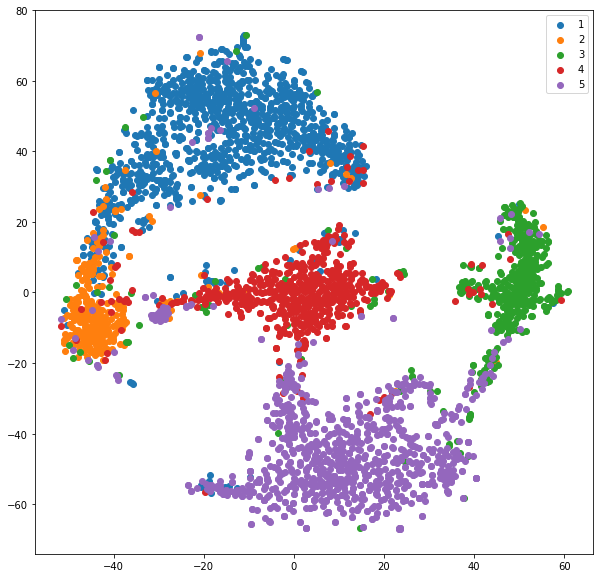

In [50]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

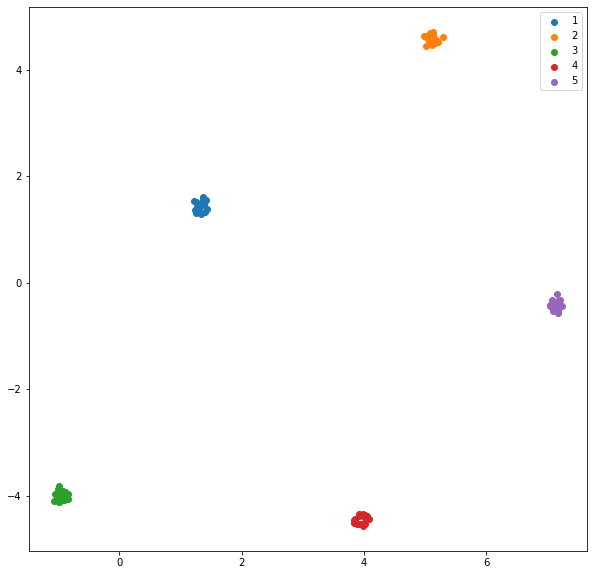

In [51]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X_train)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(y_train)):
    idx = y_train == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));